<a href="https://colab.research.google.com/github/emille42/DeepLearningNotebooks/blob/master/Gimranov_EI_HacksAI2022_(DIGITAL_KURSK_task).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import os, copy, random, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from collections import namedtuple
from IPython.display import clear_output

In [2]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import collections
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 19.6 MB/s 


In [4]:
import youtokentome as yttm

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
SEED = 2022
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Utils**

In [7]:
def build_vocab(texts, min_wrd_count=1, pad_sym=None):
  word_counts = collections.defaultdict(int)
  for text in texts:
    for word in word_tokenize(text):
      word_counts[word] +=1  
   
  word_counts = {word : count for word, count in word_counts.items() if count >= min_wrd_count}
  vocab = {word: idx+1 for idx, word in enumerate(word_counts.keys())}
  if pad_sym is not None:
    vocab[pad_sym] = len(vocab)
  return vocab, word_counts

In [8]:
def process_text(text, regx=r'[а-я]+'):
    regex = re.compile(regx)
    text = regex.findall(str(text).lower())

    ru_stemmer = SnowballStemmer('russian')
    russian_stopwords = stopwords.words("russian")

    text = [ru_stemmer.stem(word) for word in text if word not in russian_stopwords]
    text = [word for word in text if len(word) > 1]
    text = " ".join(text)
    return text

# **Dataset Exploration**

In [9]:
train_dataset = pd.read_csv("/content/drive/MyDrive/hacksAI2022/Datasets/DIGITAL_KURSK/train_dataset_train.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/hacksAI2022/Datasets/DIGITAL_KURSK/test_dataset_test.csv")

In [10]:
print(train_dataset.shape)
train_dataset.head(3)

(2000, 5)


,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1


In [11]:
print(test_dataset.shape)
test_dataset.head(3)

(1000, 4)


,id,Текст Сообщения,Тематика,Ответственное лицо
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Неработающее наружное освещение,Администрация Курчатовского района
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
2,2782,Не работает освещение во дворе дома 11а по Эне...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...


In [12]:
themes_train = train_dataset['Тематика'].unique()
themes_test = test_dataset['Тематика'].unique()
print("Уникальных тематик в тренировочных данных: ", len(themes_train))
print("Уникальных тематик в тестовых данных: ", len(themes_test))
print("Общих тематик в тестовых и тренировочных данных: ", len(np.intersect1d(themes_test, themes_train)))

Уникальных тематик в тренировочных данных:  161
Уникальных тематик в тестовых данных:  119
Общих тематик в тестовых и тренировочных данных:  107


In [13]:
organ_train = train_dataset['Ответственное лицо'].unique()
organ_test = test_dataset['Ответственное лицо'].unique()
print("Уникальных отв. лиц в тренировочных данных: ", len(organ_train))
print("Уникальных отв. лиц в тестовых данных: ", len(organ_test))
print("Общих отв. лиц в тестовых и тренировочных данных: ", len(np.intersect1d(organ_test, organ_train)))

Уникальных отв. лиц в тренировочных данных:  75
Уникальных отв. лиц в тестовых данных:  64
Общих отв. лиц в тестовых и тренировочных данных:  56


In [14]:
train_data = train_dataset.drop(['Ответственное лицо'], axis =1)

In [15]:
# Выборка несбалансирована:
print("Всего классов: ", len(train_dataset['Категория'].unique()))
train_dataset['Категория'].value_counts()

Всего классов:  17


3     954
0     478
16    149
8     139
4     108
10     48
7      27
1      25
11     19
5      12
13     11
6      10
15      7
9       5
14      4
2       3
12      1
Name: Категория, dtype: int64

In [16]:
# Предобработка текста
train_data['Текст Сообщения'] = train_data['Текст Сообщения'].apply(process_text)
test_dataset['Текст Сообщения'] = test_dataset['Текст Сообщения'].apply(process_text)

In [17]:
train_data['Тематика'] = train_data['Тематика'].apply(process_text)
test_dataset['Тематика'] = test_dataset['Тематика'].apply(process_text)

In [18]:
vocab, word_counts = build_vocab(train_data['Тематика'])
print(len(vocab))

298


In [ ]:
# Просмотрим словарь
vocab, word_counts = build_vocab(train_data['Текст Сообщения'])
word_counts_sorted = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
print(len(vocab))
# print(vocab)
# print(word_counts)
# print(word_counts_sorted)

# **Torch Utils**

In [20]:
# Функция для обучения модели
def train_model(model,epochs, optimizer, criterion, tr_dataloader,val_dataloader=None, metric_func=None, device='cpu'):
  model.to(device)
  
  history = []
  history_val = []
  history_metric = []
  history_metric_val = []
  best_model = copy.deepcopy(model)
  best_loss = 10000
  try:
      for i in range(epochs):
        
        # TRAIN
        epoch_losses = []
        epoch_metric = []
        for batch_1, batch_2, targets in tr_dataloader:
          model.train()
       
          batch_1 = batch_1.to(device)
          batch_2 = batch_2.to(device)
          targets = targets.to(device)

          pred = model(batch_1, batch_2)
          loss = criterion(pred, targets)

          optimizer.zero_grad()
          loss.backward(retain_graph=True)
          optimizer.step()

          if metric_func:
            metric = metric_func(targets.detach().cpu().numpy(), pred.detach().cpu().numpy())
            epoch_metric.append(metric)

          # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    
          loss_val = loss.cpu().data.numpy()
          epoch_losses.append(loss_val)        

        # VALIDATION
        val_losses = []
        val_metric = []
        model.eval()
        for batch_1, batch_2, targets in val_dataloader:
          with torch.no_grad():
            batch_1 = batch_1.to(device)
            batch_2 = batch_2.to(device)
            targets = targets.to(device)

            pred = model(batch_1, batch_2)

            loss = criterion(pred, targets)
            loss_val = loss.cpu().data.numpy()
            val_losses.append(loss_val)

            if metric_func:
              metric = metric_func(targets.detach().cpu().numpy(), pred.detach().cpu().numpy())        
              val_metric.append(metric)

        clear_output(True)
        mean_loss = np.mean(epoch_losses)
        history.append(mean_loss)        
        plt.plot(history, label='train loss')
        
        mean_val_loss = np.mean(val_losses)
        history_val.append(mean_val_loss)
        plt.plot(history_val, label='val loss')

        plt.legend()
        plt.show()

        if metric_func:  
          mean_metric = np.mean(epoch_metric) 
          history_metric.append(mean_metric)  
          plt.plot(history_metric, label='Metric train')

          mean_val_metric = np.mean(val_metric)
          history_metric_val.append(mean_val_metric)
          plt.plot(history_metric_val, label='Metric val')

          plt.legend()
          plt.show()
          
        print(f"Epoch: {i}. Mean train Loss:{mean_loss} ")
        print(f"Epoch: {i}. Mean val Loss:{mean_val_loss} ")

        if mean_val_loss < best_loss:
          best_loss = copy.deepcopy(mean_val_loss)
          best_model = copy.deepcopy(model)
          print(f"Find new best model: {mean_val_loss}")

  except KeyboardInterrupt:
    print("Stopped by user!")
    return best_model, best_loss 
    
  return best_model, best_loss   

In [21]:
# Функция для предсказания классов
def predict_with_model(model, dataloader):
  model.eval()
  predictions = []
  with torch.no_grad():
    for batch_1, batch_2 in dataloader:
      batch_1 = batch_1.to(device)
      batch_2 = batch_2.to(device)
      preds = model(batch_1, batch_2, predict=True)
      
      preds = preds.detach().cpu().numpy()
      for pred in preds:
        predictions.append(pred.argmax())
  return predictions

In [22]:
# Класс для работы с датасетом
class TwoTextsDataset(Dataset):
  def __init__(self, texts1,texts2, targets=None):
    self.texts1 = texts1
    self.texts2 = texts2
    self.targets = targets

  def __len__(self):
    return len(self.texts1)
  def __getitem__(self, index):
      texts1 = self.texts1[index]
      texts2 = self.texts2[index]
      
      if self.targets is None:
        return texts1,texts2
      else:
        target = self.targets[index]
        return texts1,texts2, target

# **Torch Modules**

In [23]:
# В этом разделе - модули для создания нейросети
class SimpleAttention(nn.Module):
  def __init__(self, in_ch, out_ch=1, kernel_size=3):
    super().__init__()
    self.softmax = nn.Softmax(dim=-1)
    self.convAtt = nn.Conv1d(in_channels=in_ch, out_channels=1, kernel_size=kernel_size, padding = kernel_size//2)

  def forward(self, x):
    # input: batch_size x features_num x seq_len
    att = self.convAtt(x) # batch_size x out_ch x seq_len
    att = self.softmax(att) # AttentionScores
    out = torch.matmul(att,x.permute(0,2,1))
    # out: batch x 1 x features_num
    return out

In [24]:
class SelfAttention(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size=3):
    super().__init__()
    self.key_gen = nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding = kernel_size //2)
    self.query_gen = nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, padding = kernel_size //2)
    self.softmax = nn.Softmax(dim=-1)
  
  def forward(self,x):
    # input: batch_size x features_num x seq_len
    query = self.query_gen(x) # batch_size x out_ch x seq_len
    keys = self.key_gen(x) # get keys, values (batch_size x out_ch x seq_len)
    logits = torch.matmul(query.permute(0,2,1), keys) # square matrix (batch_size x seq_len x seq_len)
    att_scores = self.softmax(logits) # (batch_size x seq_len x seq_len)
    out = torch.matmul(att_scores, keys.permute(0,2,1))
    out = out.permute(0,2,1)
    # output: batch_size x out_ch x seq_len
    return out


In [25]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, emb_size, kernel_size=3, device='cpu'):
    super().__init__()
    self.device = device
    layers = []
    for _ in range(emb_size):
      layers.append(
          nn.Sequential(SelfAttention(in_ch=emb_size, out_ch=1, kernel_size=kernel_size))
      )
    self.layers = nn.ModuleList(layers)
  def forward(self,x):
    # input: batch x features_num x seq_len
    out = torch.tensor([]).to(self.device)
    for self_att in self.layers:
      att = self_att(x) # batch x (1 x seq_len) 
      att = att.to(self.device)
      out = torch.cat((out,att), dim = 1 )
      
    # output: batch x features_num x seq_len
    
    return out



In [26]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, emb_size, device='cpu'):
    super().__init__()
    self.MH_att = MultiHeadSelfAttention(emb_size,11, device=device)
    self.norm1 = nn.LayerNorm(emb_size)
    self.ln1 = nn.Linear(emb_size, emb_size)
    self.relu = nn.ReLU()
    self.ln2 = nn.Linear(emb_size, emb_size)
    self.norm2 = nn.LayerNorm(emb_size)
  def forward(self,x):
    # input: batch X features_num X seq_len
    x = x + self.MH_att(x)
    x = self.norm1(x.permute(0,2,1))

    x_1 = self.ln1(x)
    x_1 = self.relu(x_1)
    x_1 = self.ln2(x_1)

    x = self.norm2(x + x_1)
    x = x.permute(0,2,1)
    # output: batch X features_num X seq_len
    return x

# **Torch model**

In [27]:
# Модель
class MultiAttClassifier(nn.Module):
  def __init__(self,voc_size,emb_size,seq_len,out_features=17, embedding=None, device='cpu'):
    super().__init__()
    self.device = device
    self.MH_att_1 = MultiHeadSelfAttention(emb_size, 11,device)
    self.MH_att_2 = MultiHeadSelfAttention(emb_size,3,device)
    self.att1 = SimpleAttention(emb_size)
    self.att2 = SimpleAttention(emb_size)
    self.bn1 = nn.BatchNorm1d(emb_size)
    self.ln1 = nn.Linear(emb_size, emb_size//4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(emb_size//4, out_features) 
    self.softmax = nn.Softmax(-1)

    if embedding is None:
      self.embedding = nn.Embedding(voc_size, emb_size, padding_idx=0)
    else:
      self.embedding = embedding    

  
  def forward(self, x_1, x_2, predict=False):

    x_1 = self.embedding(x_1).permute(0,2,1)
    x_1 = self.MH_att_1(x_1) # batch X emb_size X seq_len_1
    x_1 = self.bn1(x_1)

    x_2 = self.embedding(x_2).permute(0,2,1)
    x_2 = self.MH_att_2(x_2) # batch X emb_size X seq_len_2
    x_2 = self.bn1(x_2)


    x_1 = self.att1(x_1) # batch X 1 X emb_size
    x_2 = self.att2(x_2) # batch X 1 X emb_size

    x = (x_1 + x_2)/2
    x = x.squeeze(1)

    x = self.ln1(x)
    x = self.relu(x)
    out = self.out(x)
    if predict:
      out = self.softmax(out)
    return out

# **Prepare Dataset**

In [ ]:
# Здесь и далее - подготовка данных к обучению
train_data['Текст Сообщения'].to_csv('texts.txt', index=False, header=False)
BPE_VOC_SIZE = 1500
train_data_path = "texts.txt"
model_path = "bpe_text.model"
yttm.BPE.train(data=train_data_path, vocab_size=BPE_VOC_SIZE, model=model_path)
bpe_text = yttm.BPE(model=model_path)
# ' '.join(bpe_text.vocab())

In [29]:
data = train_data.append(train_data.groupby('Категория').filter(lambda x : len(x) < 2))
for i in range(5):
  data = data.append(train_data.groupby('Категория').filter(lambda x : len(x) < 2))

In [30]:
train_X = data[['Текст Сообщения', 'Тематика']]
train_Y = data['Категория']
X_train, X_val, y_train, y_val = train_test_split(train_X,train_Y, test_size=0.2, random_state=SEED, stratify=train_Y)

In [31]:
len(y_val.unique()), len(y_train.unique())

(17, 17)

In [32]:
train = pd.DataFrame(X_train).join(y_train)

In [33]:
for i in range(3):
  rare_rows = train.groupby('Категория').filter(lambda x : len(x) < 50)
  rare_cats = rare_rows['Категория'].unique()
  for i in range(train.shape[0]):
    row = train.iloc[[i]]
    category = row['Категория'].values[0]
    if category in rare_cats:
      train = train.append(row)

In [34]:
train['Категория'].value_counts()

3     763
0     382
16    119
8     111
7      88
4      86
1      80
5      80
10     76
13     72
12     72
6      64
11     60
15     48
9      32
14     24
2      16
Name: Категория, dtype: int64

In [35]:
X_train_text = train['Текст Сообщения'].to_numpy()
X_train_themes = train['Тематика'].to_numpy()
y_train = train['Категория'].to_numpy()

X_val_text = X_val['Текст Сообщения'].to_numpy()
X_val_themes = X_val['Тематика'].to_numpy()
y_val = y_val.to_numpy()

In [36]:
train_encoded = bpe_text.encode(X_train_text.tolist(),output_type=yttm.OutputType.ID)
texts_lens = [len(text) for text in train_encoded]
print(np.mean(texts_lens))
print(np.median(texts_lens))
print(max(texts_lens))
train_encoded = [torch.tensor(text) for text in train_encoded]
train_matrix_text = pad_sequence(train_encoded, batch_first=True).numpy()

train_encoded = bpe_text.encode(X_train_themes.tolist(),output_type=yttm.OutputType.ID)
texts_lens = [len(text) for text in train_encoded]
print(np.mean(texts_lens))
print(np.median(texts_lens))
print(max(texts_lens))
train_encoded = [torch.tensor(text) for text in train_encoded]
train_matrix_themes = pad_sequence(train_encoded, batch_first=True).numpy()

64.92268752876208
42.0
1279
11.10124252185918
10.0
27


In [37]:
val_encoded = bpe_text.encode(X_val_text.tolist(),output_type=yttm.OutputType.ID)
val_encoded = [torch.tensor(text) for text in val_encoded]
val_matrix_text = pad_sequence(val_encoded, batch_first=True).numpy()

val_encoded = bpe_text.encode(X_val_themes.tolist(),output_type=yttm.OutputType.ID)
val_encoded = [torch.tensor(text) for text in val_encoded]
val_matrix_themes = pad_sequence(val_encoded, batch_first=True).numpy()

In [38]:
max_text_len = 130
train_matrix_text = np.array([text[:max_text_len] for text in train_matrix_text])
val_matrix_text = np.array([text[:max_text_len] for text in val_matrix_text])

max_theme_len = 30
train_matrix_themes = np.array([text[:max_theme_len] for text in train_matrix_themes])
val_matrix_themes = np.array([text[:max_theme_len] for text in val_matrix_themes])

In [39]:
test_X_text = test_dataset['Текст Сообщения'].to_numpy()
test_X_theme = test_dataset['Тематика'].to_numpy()

In [40]:
test_encoded = bpe_text.encode(test_X_text.tolist(),output_type=yttm.OutputType.ID)
test_encoded = [torch.tensor(text) for text in test_encoded]
test_matrix = pad_sequence(test_encoded, batch_first=True).numpy()
test_matrix_text = np.array([text[:max_text_len] for text in test_matrix])

test_encoded = bpe_text.encode(test_X_theme.tolist(),output_type=yttm.OutputType.ID)
test_encoded = [torch.tensor(text) for text in test_encoded]
test_matrix = pad_sequence(test_encoded, batch_first=True).numpy()
test_matrix_themes = np.array([text[:max_theme_len] for text in test_matrix])

In [41]:
train_matrix_text.shape, val_matrix_text.shape,  test_matrix_text.shape

((2173, 130), (402, 130), (1000, 130))

In [42]:
train_matrix_themes.shape, val_matrix_themes.shape,  test_matrix_themes.shape

((2173, 27), (402, 24), (1000, 27))

In [43]:
train_d = TwoTextsDataset(train_matrix_text,train_matrix_themes, y_train)
train_dataloader = DataLoader(train_d,batch_size=100, shuffle=True, drop_last=True)

val_d = TwoTextsDataset(val_matrix_text,val_matrix_themes, y_val)
val_dataloader = DataLoader(val_d,batch_size=100, shuffle=True, drop_last=True)

test_d = TwoTextsDataset(test_matrix_text, test_matrix_themes)
test_dataloader = DataLoader(test_d, batch_size=test_matrix.shape[0])

In [44]:
n_classes = len(train_data['Категория'].unique())

# **Train model**

In [45]:
# Тренируем модель
model_1 = MultiAttClassifier(voc_size=BPE_VOC_SIZE, emb_size=75, 
                                seq_len=max_text_len, out_features=n_classes, device=device)
model_1 = model_1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters())

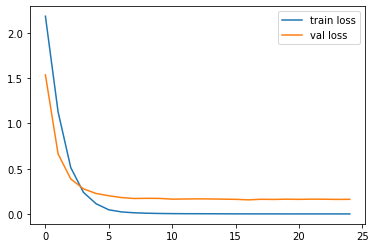

Epoch: 24. Mean train Loss:0.00036880956031382084 
Epoch: 24. Mean val Loss:0.1615791916847229 


In [46]:
best_model_1, best_loss = train_model(model_1, 25, optimizer, criterion, train_dataloader, val_dataloader,device=device)

In [47]:
best_loss

0.15573451

In [48]:
pred_test = predict_with_model(best_model_1, test_dataloader)

In [49]:
pred_df = pd.DataFrame()
pred_df['id'] = test_dataset['id']
pred_df['Категория'] = pred_test
# pred_df.to_csv('submit.csv', index=False)
pred_df.head(3)

,id,Категория
0,843,3
1,1422,3
2,2782,3


In [50]:
train_dataset['Категория'].value_counts()

3     954
0     478
16    149
8     139
4     108
10     48
7      27
1      25
11     19
5      12
13     11
6      10
15      7
9       5
14      4
2       3
12      1
Name: Категория, dtype: int64

In [51]:
pred_df['Категория'].value_counts()

3     517
0     235
16     61
8      58
4      52
10     27
1      14
7      13
5       8
11      5
6       4
15      3
13      2
2       1
Name: Категория, dtype: int64